# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import sys
sys.path.append("..")
from scem import ebm, stein, kernel, util, gen
from scem.datasets import *
import matplotlib.pyplot as plt

In [3]:
dname = "banana"
p = load_data(dname, D=2, noise_std = 0.0, seed=0, itanh=False, whiten=False )

x = p.sample(1000)
x_eval = p.sample(100)

In [4]:
import torch 
import torch.nn as nn
import numpy as np
import torch.distributions as td


class EBM(nn.Module):
    
    '''
    EBM 
    '''
    
    def __init__(self, Dx, Dz, Dh):
        
        super().__init__()
        
        self.layer_1 = nn.Linear(Dz+Dx, Dh)
        self.layer_2 = nn.Linear(Dh, 1)
    
    def forward(self, X, Z):
        elu = nn.ELU()


        XZ = torch.cat([X, Z], axis=-1)
        h  = elu(self.layer_1(XZ))
        E  = self.layer_2(h)
        return E[:,0]
    

# dimensionality of model 
Dx = 2
Dz = 2
Dh = 100

lebm = ebm.LatentEBMAdapter(EBM(Dx, Dz, Dh), var_type_obs='continuous', var_type_latent='continuous')

In [5]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [6]:
X = torch.as_tensor(x, dtype=torch.float32)

In [7]:
# define kernel

med2 = util.pt_meddistance(X)**2
#kx = kernel.KIMQ(b=-0.5, c=1, s2=med2)
kx = kernel.PTKGauss(torch.tensor([med2]))

In [8]:
# q(z|x)
cs = gen.CSFactorisedGaussian(Dx, Dz, Dh)


# optimizer settings
learning_rate_q = 1e-2
weight_decay_q =  0.#1e-5
optimizer_q = torch.optim.Adam(cs.parameters(), lr=learning_rate_q,
                               weight_decay=weight_decay_q)

approx_score = stein.ApproximateScore(
        lebm.score_joint_obs, cs)
approx_score.n_sample = 500

# optimizer settings for p(x)
learning_rate_p = 1e-1 # !!!
weight_decay_p = 0.
optimizer_p = torch.optim.Adam(lebm.parameters(), lr=learning_rate_p,
                               weight_decay=weight_decay_p)

In [9]:
iter_p = 40
iter_q = 200
batch_size = 100

In [10]:
def inner_loop(niter, X, cs, opt):
    for i in range(niter):
        Z = cs.sample(1, X)
        Z = Z.squeeze(0)
        zmed2 = util.pt_meddistance(Z)**2
        kz = kernel.KIMQ(b=-0.5, c=1, s2=1)
        loss = stein.kcsd_ustat(
            X, Z, lebm.score_joint_latent, kx, kz)
        opt.zero_grad()
        loss.backward(retain_graph=False)
        opt.step()   
    print('kcsd', loss.item())
    

In [11]:
#inner_loop(400, X)
losses = []

for t in range(iter_p):
    # reset q(z|x)'s weight
    cs.apply(weight_reset)
    optimizer_q = torch.optim.Adam(cs.parameters(), lr=learning_rate_q,
                               weight_decay=weight_decay_q)
    
    perm = torch.randperm(X.shape[0]).detach()
    idx = perm[:batch_size]
    X_ = X[idx].detach()

    inner_loop(iter_q, X_, cs, optimizer_q)
    loss = stein.ksd_ustat(X_, approx_score, kx)  
    losses += [loss.item()]

    if (t%10 == 0):
        loss_ = stein.ksd_ustat(X, approx_score, kx).item()
        print(loss.item(), loss_)
    
    optimizer_p.zero_grad()
    loss.backward(retain_graph=False)
    optimizer_p.step()

kcsd -0.0017496035434305668
0.13770006597042084 0.1450061947107315
kcsd -0.0015418236143887043
kcsd -0.0031445666681975126
kcsd -0.0027759806253015995
kcsd 0.0008187326602637768
kcsd 0.005540942773222923
kcsd 0.006610617507249117
kcsd 0.007109937723726034
kcsd 0.0031338685657829046
kcsd 0.0010030480334535241
kcsd -0.0009887063642963767
0.11992599070072174 0.22634564340114594
kcsd -0.0014519632095471025
kcsd -0.00037117389729246497
kcsd -0.001333593507297337
kcsd -0.0014787570107728243
kcsd -0.0011830262374132872
kcsd -0.00035617558751255274
kcsd 0.00029654300305992365
kcsd 0.0028582115191966295
kcsd 0.002673435490578413
kcsd 0.005654340144246817
0.11132635176181793 28.85780906677246
kcsd -0.00012186223466414958
kcsd 0.00276897381991148
kcsd 0.002005297690629959
kcsd 0.0008695613942109048
kcsd 0.0013461180496960878
kcsd 0.0029003876261413097
kcsd -0.00043580489000305533
kcsd -0.0007876324816606939
kcsd -0.0007344702607952058
kcsd -0.000932410650420934
0.09574270248413086 0.0584086552262

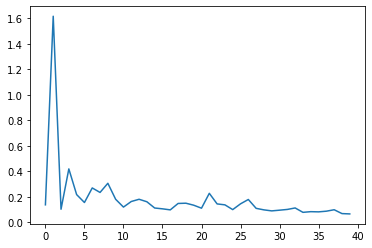

In [12]:
plt.plot(losses)

In [13]:
# form a grid for numerical normalisation
from itertools import product
ngrid = 50
grid = torch.linspacddde(-10, 10, ngrid)
xz_eval = torch.tensor(list(product(*[grid]*4)))
x_eval = xz_eval[:,:2]
z_eval = xz_eval[:,2:]

AttributeError: module 'torch' has no attribute 'linspacddde'

In [ ]:
# true log density
E_true = p.logpdf_muddltiple(torch.tensor(list(product(*[grid]*2))))
E_true -= E_true.max()

In [ ]:
# EBM log density
E_eval = lebm(x_eval, z_eval).reshape(ngrid,ngrid,ngrid,ngrid).exp().detach()
E_eval /= E_eval.sum()
E_eval = E_eval.sum(-1).sum(-1)
E_eval.log_()
E_eval -= E_eval.max()
# E_eval = E_eval.sum(-1).sum(-1)

In [ ]:
def normalise(E):
    if isinstance(E, np.ndarray):
        E = np.exp(E)
    else:
        E = E.exp()
    E /= E.sum()
    return E

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)


ax = axes[0,0]
ax.pcolor(grid, grid,E_true.reshape(ngrid,ngrid), shading='auto', vmin=-10, vmax=0)
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)


ax = axes[1,0]
ax.pcolor(grid, grid,normalise(E_true).reshape(ngrid,ngrid), shading='auto')

ax = axes[0,1]
ax.pcolor(grid, grid,E_eval,shading='auto', vmin=-10, vmax=0, )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)

ax = axes[1,1]
ax.pcolor(grid, grid,normalise(E_eval),shading='auto' )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.0)



axes[0,0].set_ylabel("logp")
axes[1,0].set_ylabel("logp")

axes[0,0].set_title("data")
axes[0,1].set_title("VNCE")

axes[0,0].set_xlim(-10,10)